# SNe Ia Simulations

The goal of this notebook is to carry out a set of spectral simulations which include SNe Ia templates in the host-galaxy spectra.

### Begin: code from Or Graur to be incorporated.

In [ ]:
import os
import sys
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline

In [ ]:
ngal=500
seed=123
rand = np.random.RandomState(seed)

In [ ]:
# tts is a MxN matrix where M is the number of days for which there are templates and N is the wavelength range
# wws gives the wavelength range
hsiao = fits.open('/home/orgraur/programs/desi/spectro/templates/basis_templates/v2.1/sne_templates_v1.0.fits')
tts = hsiao[0].data
wws = np.arange(100,25000,10)

In [ ]:
# SN Ia LF from Richardson et al. (2014), Table 1
M_B = -19.25 
M_sig = 0.5 
alpha = 1.52

In [ ]:
# Johnson B-band light curve template
#   (0) - epoch relative to B-band maximum [day]
#   (1) - B mag [AB]
#   (2) - SDSS r' mag
#   (3) - DECAM_2014 r mag
#   (4) - DECAM_2014 z mag
lc_data = loadmat('trunk/light_curve_B_normalized_DESI.mat' )
lc = lc_data['lc']
days = lc_data['lc'][:,0]
L0 = lc_data['lc'][:,1]

In [ ]:
# load the color correction vector (going from R to DECAM r', for BSG, or DECAM z', for LRG)
survey = 1 # let's go with BGS as the default
if survey == 1:
    color = loadmat('/home/orgraur/matlab/desi/decam_r_color.mat')
else:
    color = loadmat('/home/orgraur/matlab/desi/decam_z_color.mat')
color = color['color'][:,0]

In [ ]:
# choose which SN templates to use
tempint = 0 # easy way - use integer template IDs and phases
if tempint == 0:
    # random SN template IDs
    sntemp = rand.randint(0, len(days), size=ngal)
    phase = days[sntemp] # the phases of those SN templates
else:
    # Choose the phase with uniform probability between the min/max (ignoring template ID).
    phase = rand.uniform(days.min(), days.max(), size=ngal)
    # this is where we would interpolate between templates... not necessary for now

In [ ]:
# calculate the distance modulii of the redshifts generated above
dm = cosmo.distmod(redshift)

In [ ]:
# generate random stretch values

# stretch vs epoch relation
smag = loadmat('trunk/stretch_mag.mat')

m = rand.normal(0, M_sig, size=ngal)

s = -0.6579*m +1
x = np.where(np.logical_or(s<0.6, s>1.4))[0]
#print(m[x])
while len(x) != 0:
    x = np.where(np.logical_or(s<0.6, s>1.4))[0]
    m[x] = rand.normal(0, M_sig, size=len(x))
    s[x] = -0.6579*m[x] +1
    
M = M_B + m # randomize the absolute magnitudes

In [ ]:
factor = np.zeros(ngal)
for i in range(0, ngal):
    f_host = 10**(-0.4*(rgal[i]+48.6)) # host-galaxy r'-band mag
    
    # stretch the fiducial SN Ia light curve and get the SN Ia mag
    lightcurves = [lc[:,0]*s[i], lc[:,1]-alpha*(s[i]-1)]
    fun = interpolate.interp1d(lightcurves[0], lightcurves[1], fill_value='extrapolate')
    LC_interp = fun(days)
    Norm=-L0+LC_interp
    
    fun1 = interpolate.interp1d(lightcurves[0],Norm, fill_value='extrapolate')
    fun2 = interpolate.interp1d(days,color, fill_value='extrapolate')
    
    mag_sn = M[i] + dm[i].value + fun1(phase[i]) + fun2(phase[i])
    
    f_sn = 10**(-0.4*(mag_sn+48.6))
    factor[i] = f_sn/f_host # the flux factor between the SN and host galaxy
    
fig = plt.hist(factor)

### End code from Or

In [1]:
import os
import numpy as np

import fitsio
import healpy as hp
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
import desisim.io
import desispec.io
import desimodel.io 

from desisim.obs import new_exposure
from desisim.scripts import quickgen
from desisim.templates import specify_galparams_dict

from desispec.scripts import group_spectra

/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
%matplotlib inline

### Simulation number and input priors

In [4]:
sim = 1
program = 'BGS'

seed = 678245
nexp = 5
nspec = 10

In [5]:
rmagrange = (19.0, 19.0)
zrange = (0.2, 0.2)
sne_rfluxratiorange = (0.5, 0.5)

In [6]:
airmass_range = (1.0, 1.0)
seeing_range = (1.0, 1.0)
moon_phase_range = (0.25, 0.25)
moon_zenith_range = (30, 30)
exptime_range = (600, 600)
moon_angle_range = (0, 150)

In [7]:
simint = int(sim)
simname = '{:02d}'.format(simint)
night = '2017{}{}'.format(simname, simname)
expids = np.arange(nexp) + simint*1000
print('Simulation name = {}, Night = {}, Number of exposures = {}'.format(simname, night, nexp))
print('Exposure IDs = {}'.format(expids))

Simulation name = 01, Night = 20170101, Number of exposures = 5
Exposure IDs = [1000 1001 1002 1003 1004]


### Define the I/O simulation directories.

In [8]:
os.environ['PIXPROD'] = 'snesim-{}'.format(simname)
os.environ['SPECPROD'] = 'snesim-{}'.format(simname)
os.environ['DESI_SPECTRO_DATA'] = desisim.io.simdir()

print('Simulated raw data will be written to {}'.format(desisim.io.simdir()))
print('Pipeline will read raw data from {}'.format(desispec.io.rawdata_root()))
print('Pipeline will write processed data to {}'.format(desispec.io.specprod_root()))

Simulated raw data will be written to /Users/ioannis/work/desi/spectro/sim/snesim-01/
Pipeline will read raw data from /Users/ioannis/work/desi/spectro/sim/snesim-01/
Pipeline will write processed data to /Users/ioannis/work/desi/spectro/redux/snesim-01


### Assign exposures to different tiles.

This step is necessary to keep the spectra from all stacking on the default tile, and ensures that each tile will have a dedicated set of observing conditions.

In [9]:
tiles = desimodel.io.load_tiles()
xyz = hp.ang2vec(tiles['ra'], tiles['dec'], lonlat=True)
center = hp.ang2vec(130, 18, lonlat=True)
d2 = ((xyz - center)**2).sum(axis=1)
tiles = tiles[np.argsort(d2)[0:nexp]]
print('Selecting the following tiles:')
Table(tiles)

Selecting the following tiles:


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
22594,130.08,18.03,3,1,0.0255654,1.06033,2664.73,1.25706,DARK,1
40476,129.32,17.9,7,1,0.0281447,1.06097,2753.01,1.27791,BRIGHT,4
16832,128.99,18.05,2,1,0.0298504,1.06023,2795.41,1.29012,DARK,1
28356,131.17,18.02,4,1,0.0231459,1.06038,2514.4,1.23876,GRAY,2
11069,130.26,16.58,1,1,0.0251414,1.06783,2711.23,1.26491,DARK,1


In [10]:
nside = 64 
pixels = desimodel.footprint.tiles2pix(nside, tiles)
print('Healpix pixels = {}'.format(pixels))

Healpix pixels = [4330 4331 4334 4335 4346 4672 4673 4674 4675 4676 4677 4678 4679 4680 4681
 4682 4683 4684 4685 4686 4687 4688 4689 4690 4691 4694 4696 4697 4698 4699
 4705 4708 4709 4710 4720]


### Generate nexp uniform samplings of the simulation parameters.

In [11]:
rand = np.random.RandomState(seed)

In [12]:
seeds = rand.randint(2**32, size=nexp)
seeings = rand.uniform(seeing_range[0], seeing_range[1], nexp)
exptimes = rand.uniform(exptime_range[0], exptime_range[1], nexp)
airmasses = rand.uniform(airmass_range[0], airmass_range[1], nexp)
moonphases = rand.uniform(moon_phase_range[0], moon_phase_range[1], nexp)
moonangles = rand.uniform(moon_angle_range[0], moon_angle_range[1], nexp)
moonzeniths = rand.uniform(moon_zenith_range[0], moon_zenith_range[1], nexp)

In [13]:
allobj_specs = dict()
allobj_specs[program] = specify_galparams_dict(
    program, 
    zrange = zrange,
    magrange = rmagrange, 
    sne_rfluxratiorange = sne_rfluxratiorange,
    add_SNeIa = True,
)
print(allobj_specs[program])

{'zrange': (0.2, 0.2), 'rmagrange': (19.0, 19.0), 'add_SNeIa': True, 'sne_rfluxratiorange': (0.5, 0.5)}


In [14]:
for ii in range(1):
    obsconditions = {'SEEING' : seeings[ii], 'EXPTIME': exptimes[ii], 'AIRMASS': airmasses[ii],
                     'MOONFRAC': moonphases[ii], 'MOONALT': moonzeniths[ii], 'MOONSEP': moonangles[ii]}
    
    sim, fibermap, meta, obsconditions = new_exposure(program=program, seed=seeds[ii],
                                                      nspec=nspec, night=night,
                                                      expid=expids[ii], tileid=tiles[ii][0],
                                                      obsconditions=obsconditions, 
                                                      specify_targets=allobj_specs,
                                                      overwrite=True)
    
    quickgen_args = quickgen.parse([
        '--simspec', desisim.io.findfile('simspec', night, expids[ii]),
        '--fibermap', desisim.io.findfile('simfibermap', night, expids[ii]),
        '--seed', str(seeds[ii])
    ])
    quickgen.main(quickgen_args)

DEBUG:obs.py:101:new_exposure: Generating 10 targets
DEBUG:targets.py:195:get_targets_parallel: Not Parallelizing get_targets for only 10 targets
DEBUG:targets.py:262:get_targets: Using random seed 1800636030
INFO:io.py:787:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
INFO:io.py:787:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/sne_templates_v1.0.fits
DEBUG:templates.py:361:_blurmatrix: Populating blur matrix with 1 unique velocity dispersion values.
INFO:io.py:787:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
DEBUG:simexp.py:371:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:375:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:396:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:

/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


DEBUG:simexp.py:518:get_source_types: bgs 7 targets
DEBUG:simexp.py:518:get_source_types: sky 2 targets
DEBUG:simexp.py:518:get_source_types: star 1 targets
DEBUG:simexp.py:436:simulate_spectra: running simulation
INFO:io.py:147:write_simspec: DATE-OBS 2017-01-01T22:00:00 UTC
INFO:io.py:223:write_simspec: Writing /Users/ioannis/work/desi/spectro/sim/snesim-01/20170101/simspec-00001000.fits


INFO:obs.py:211:new_exposure: Wrote /Users/ioannis/work/desi/spectro/sim/snesim-01/20170101/fibermap-00001000.fits
Commenting out update_obslog!!!
INFO:quickgen.py:239:main: Reading fibermap file /Users/ioannis/work/desi/spectro/sim/snesim-01/20170101/fibermap-00001000.fits
DEBUG:simexp.py:518:get_source_types: bgs 7 targets
DEBUG:simexp.py:518:get_source_types: sky 2 targets
DEBUG:simexp.py:518:get_source_types: star 1 targets
INFO:quickgen.py:272:main: Initializing SpecSim with config desi
DEBUG:specsim.py:39:get_simulator: Creating new desi Simulator
INFO:quickgen.py:278:main: Reading input file /Users/ioannis/work/desi/spectro/sim/snesim-01/20170101/simspec-00001000.fits
INFO:quickgen.py:314:main: Only 10 spectra in input file
INFO:quickgen.py:677:main: Writing files for channel:b, spectrograph:0, spectra:0 to 10
INFO:quickgen.py:704:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01/exposures/20170101/00001000/frame-b0-00001000.fits
INFO:quickgen.py:722:main: Wrote 

INFO:quickgen.py:722:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01/exposures/20170101/00001000/cframe-r0-00001000.fits
INFO:quickgen.py:737:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01/exposures/20170101/00001000/sky-r0-00001000.fits
INFO:quickgen.py:758:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01/exposures/20170101/00001000/calib-r0-00001000.fits
INFO:quickgen.py:677:main: Writing files for channel:z, spectrograph:0, spectra:0 to 10
INFO:quickgen.py:704:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01/exposures/20170101/00001000/frame-z0-00001000.fits
INFO:quickgen.py:722:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01/exposures/20170101/00001000/cframe-z0-00001000.fits
INFO:quickgen.py:737:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01/exposures/20170101/00001000/sky-z0-00001000.fits
INFO:quickgen.py:758:main: Wrote file /Users/ioannis/work/desi/spectro/redux/snesim-01

In [15]:
simspecfits = fitsio.FITS(desisim.io.findfile('simspec', night, expids[0]))
simspecfits


  file: /Users/ioannis/work/desi/spectro/sim/snesim-01/20170101/simspec-00001000.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       WAVE
  1      IMAGE_HDU       FLUX
  2      IMAGE_HDU       SKYFLUX
  3      IMAGE_HDU       WAVE_B
  4      IMAGE_HDU       PHOT_B
  5      IMAGE_HDU       SKYPHOT_B
  6      IMAGE_HDU       WAVE_R
  7      IMAGE_HDU       PHOT_R
  8      IMAGE_HDU       SKYPHOT_R
  9      IMAGE_HDU       WAVE_Z
  10     IMAGE_HDU       PHOT_Z
  11     IMAGE_HDU       SKYPHOT_Z
  12     BINARY_TBL      TRUTH
  13     BINARY_TBL      FIBERMAP
  14     BINARY_TBL      OBSCONDITIONS

In [16]:
Table(simspecfits['OBSCONDITIONS'].read())

AIRMASS,EXPTIME,MOONALT,MOONFRAC,MOONSEP,SEEING
float64,float64,float64,float64,float64,float64
1.0,600.0,30.0,0.25,122.144765125,1.0


In [17]:
Table(simspecfits['TRUTH'].read())

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
bytes10,bytes10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
BGS,,1486,615974893,0.2,19.0,9.05856,25.1189,36.3922,29.6011,23.9983,-1.0,0.0,-1.0,0.0,1.68271,101.393,0.812913,-0.577526,0.0148598,0.0287722,-0.223423,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,453,2388722153,0.2,19.0,14.5668,25.1189,34.5096,32.1215,26.6477,-1.0,0.0,-1.0,0.0,1.66012,101.393,0.844736,0.244524,0.441384,-0.471636,-0.451952,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,2106,1537356348,0.2,19.0,19.0935,25.1189,25.8174,17.5885,16.3384,-1.0,5.37215e-16,-1.0,11.7057,1.15039,101.393,0.786791,0.806695,0.0114448,-1.56563,-1.0452,-1.0,-1.0,-1.0,-1.0,-1.0
SKY,,-1,-1,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
FSTD,,533,615974893,0.000524233,16.3556,216.471,286.929,315.509,84.3881,47.2535,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6000.0,4.0,-2.5
BGS,,3080,1395253339,0.2,19.0,8.55577,25.1189,38.4547,39.6557,33.1323,-1.0,0.0,-1.0,0.0,1.91616,101.393,0.802047,-0.0335126,0.438712,-0.192215,-0.470078,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,3222,2109587489,0.2,19.0,18.0005,25.1189,27.5125,25.0472,23.7713,-1.0,4.70925e-16,-1.0,9.71795,1.18718,101.393,0.827255,-0.320544,0.262373,0.0184941,0.167621,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,3144,1765536105,0.2,19.0,10.7055,25.1189,36.292,36.9685,28.9585,-1.0,0.0,-1.0,0.0,1.97526,101.393,0.681986,-0.272869,0.303555,0.112697,0.0176023,-1.0,-1.0,-1.0,-1.0,-1.0
SKY,,-1,-1,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [18]:
Table(simspecfits['FIBERMAP'].read())

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR
bytes10,bytes20,bytes8,int64,int64,int64,int64,float32,bytes40,int32,int64,int32,int32,int32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
BGS,,1300p187,7406197882867160669,1152921504606846976,2,0,20.1074 .. 19.0496,DECAM_G .. WISE_W2,0,95,95,95,0,0,5400.0,130.097807355,18.7478748417,130.097807355,18.7478748417,-4.13464340313,-176.016389199,-4.13464340313,-176.016389199,0.0,0.0
BGS,,1303p187,6257323788419429938,1152921504606846976,2,0,19.5916 .. 18.9359,DECAM_G .. WISE_W2,0,62,62,62,0,1,5400.0,130.276470593,18.6714981019,130.276470593,18.6714981019,-45.5863791815,-157.134697634,-45.5863791815,-157.134697634,0.0,0.0
BGS,,1303p187,8774121736903493301,1152921504606846976,2,0,19.2978 .. 19.467,DECAM_G .. WISE_W2,0,102,102,102,0,2,5400.0,130.287445012,18.8215394291,130.287445012,18.8215394291,-48.26471976,-194.58679079,-48.26471976,-194.58679079,0.0,0.0
SKY,,1303p187,2033231820972197058,4294967296,0,0,0.0 .. 0.0,..,0,82,82,82,0,3,5400.0,130.216005387,18.7340760901,130.216005387,18.7340760901,-31.5795923296,-172.635369698,-31.5795923296,-172.635369698,0.0,0.0
STD,,1300p187,4224267853333412402,8589934592,0,0,16.6615 .. 18.3139,DECAM_G .. WISE_W2,0,131,131,131,0,4,5400.0,130.051321755,18.8492200271,130.051321755,18.8492200271,6.67200636809,-201.385810488,6.67200636809,-201.385810488,0.0,0.0
BGS,,1300p187,8093418779481343928,1152921504606846976,2,0,20.1694 .. 18.6994,DECAM_G .. WISE_W2,0,108,108,108,0,5,5400.0,130.023453433,18.7701510533,130.023453433,18.7701510533,13.1352857547,-181.585171402,13.1352857547,-181.585171402,0.0,0.0
BGS,,1300p187,8370050490150094129,1152921504606846976,2,0,19.3618 .. 19.0599,DECAM_G .. WISE_W2,0,119,119,119,0,6,5400.0,130.037330449,18.8097688704,130.037330449,18.8097688704,9.91914629057,-191.490598774,9.91914629057,-191.490598774,0.0,0.0
BGS,,1300p187,4845693505715794167,1152921504606846976,2,0,19.926 .. 18.8456,DECAM_G .. WISE_W2,0,64,64,64,0,7,5400.0,130.188403599,18.6544586893,130.188403599,18.6544586893,-25.1362017254,-152.830188325,-25.1362017254,-152.830188325,0.0,0.0
SKY,,1303p187,7961454327049367540,4294967296,0,0,0.0 .. 0.0,..,0,72,72,72,0,8,5400.0,130.246304175,18.70280919,130.246304175,18.70280919,-38.5997312986,-164.880825023,-38.5997312986,-164.880825023,0.0,0.0


### Regroup the simulated spectra.

In [20]:
group_spectra.main(group_spectra.parse(['--hpxnside',str(nside)]))

INFO:group_spectra.py:74:main: Starting at Fri Sep 29 16:25:29 2017
INFO:group_spectra.py:75:main:   using raw dir /Users/ioannis/work/desi/spectro/sim/snesim-01
INFO:group_spectra.py:76:main:   using spectro production dir /Users/ioannis/work/desi/spectro/redux/snesim-01
INFO:group_spectra.py:197:main: Distributing 3 spectral groups among 1 processes
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-4685 at Fri Sep 29 16:25:29 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-4685 at Fri Sep 29 16:25:30 2017
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-4687 at Fri Sep 29 16:25:30 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-4687 at Fri Sep 29 16:25:32 2017
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-4696 at Fri Sep 29 16:25:32 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-4696 at Fri Sep 29 16:25:33 2017
INFO:group_spect

In [21]:
specfile = desispec.io.findfile('spectra', nside=nside, groupname='4685')
specfits = fitsio.FITS(specfile)
specfits


  file: /Users/ioannis/work/desi/spectro/redux/snesim-01/spectra-64/46/4685/spectra-64-4685.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       B_WAVELENGTH
  3      IMAGE_HDU       B_FLUX
  4      IMAGE_HDU       B_IVAR
  5      IMAGE_HDU       B_MASK
  6      IMAGE_HDU       B_RESOLUTION
  7      IMAGE_HDU       Z_WAVELENGTH
  8      IMAGE_HDU       Z_FLUX
  9      IMAGE_HDU       Z_IVAR
  10     IMAGE_HDU       Z_MASK
  11     IMAGE_HDU       Z_RESOLUTION
  12     IMAGE_HDU       R_WAVELENGTH
  13     IMAGE_HDU       R_FLUX
  14     IMAGE_HDU       R_IVAR
  15     IMAGE_HDU       R_MASK
  16     IMAGE_HDU       R_RESOLUTION

In [22]:
print('Reading {}'.format(specfile))
specobj = desispec.io.read_spectra(specfile)

Reading /Users/ioannis/work/desi/spectro/redux/snesim-01/spectra-64/46/4685/spectra-64-4685.fits


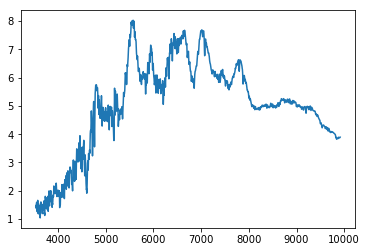

In [27]:
simwave, simflux = simspecfits['WAVE'][:], simspecfits['FLUX']
fig, ax = plt.subplots()
ax.plot(simwave, simflux[0, :].flat)

In [35]:
def makeplot(thisone=0, ylim=None):
    fig, ax = plt.subplots()
    for camera, color in zip( ('b', 'r', 'z'), ('blue', 'red', 'magenta') ):
        ax.plot(specobj.wave[camera], specobj.flux[camera][thisone], color=color)
        #ax.plot(specobj.wave[camera], specobj.ivar[camera][thisone], color=color)

    simwave, simflux = simspecfits['WAVE'][:], simspecfits['FLUX']
    plt.plot(simwave, simflux[thisone, :].flat)

    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel('Wavelength (A)')
    ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')

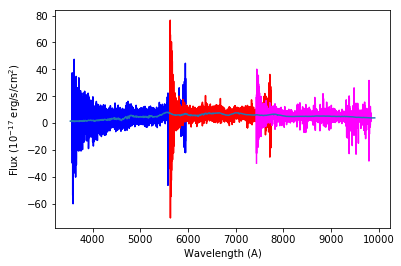

In [36]:
makeplot(thisone=0)

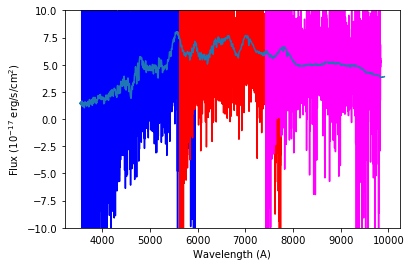

In [37]:
makeplot(thisone=0, ylim=(-10, 10))